In [1]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import scipy.stats 
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.regression.linear_model as lm
import statsmodels.api as sm

pd.get_option("display.max_columns", None)

20

# Final Project - Advanced Statistical Thinking 

#### Executive Summary 

In this project, we aim to understand what variables effect Cook County's property appeals process - in particular, we aim to understand what causes an appeal to be granted as well as what factors affect the size of the appeals granted. In the first part of the project, we answer the first question using a binary classifier. In the second part of the project, we use a multivariate OLS to answer our question. In the end, we find that there are certain variables such as property sale value, if the property is a condo or not, and location of the property to be important factors in both determining whether an appeal will be granted, and if it is, what the size of that appeal would be. There are additional factors that we include in the OLS model to predict the size of the appeal granted such as walkability factor and race of the people living at the property. 


# Question 1

What variables influence whether a property owner appeals? To what extent do factors like race or median income play a part?

Notes on the data:
- race variables are percentages of the racial group in the property's census tract. This is a very inexact proxy for the race of the homeowner. This will also cause the regression model to be noisy for neighborhoods with more equal distributions of racial groups. Also, the data fails to capture people who are multiracial.
- as discussed in the TA session, av1 is a mysterious field whose meaning isn't quite clear, so we will disregard it.

In [2]:
df = pd.read_csv('project2data.csv')

In [3]:
#### Transforms

count = len(df)
df = df.drop_duplicates().copy()
print(f"{count - len(df)} duplicate rows dropped")

# drop rows where squarefoot == 0; these are land plots maybe?
df = df[ df['squarefoot'] != 0]

# note that we don't call dropna() right away; we need to retain the meaningful NA
# values in appeal field

# create appeal_flag field with 0/1 value
df['appeal_flag'] = df['appeal'].apply(lambda val: 0 if pd.isna(val) else 1)

df['condo_flag'] = df['condo'].apply(lambda val: 1 if val == 'Condominium' else 0)

# create tax rate
df['tax_rate'] = df['taxes'] / df['value'] * 100

# take the log of value
df['value_log'] = np.log(df['value'])

# take the log of medhinc
df['medhinc_log'] = np.log(df['medhinc'])

# take the log of squarefoot
df['squarefoot_log'] = np.log(df['squarefoot'])

# multiply percentages stored as a decimal to percentage points, to make it
# easier to interpret APEs
df['college'] = df['college']*100
df['white'] = df['white']*100
df['black'] = df['black']*100
df['hispanic'] = df['hispanic']*100
df['asian'] = df['asian']*100

tri_dummies = pd.get_dummies(df['tri'])
df['tri_chicago'] = tri_dummies['Chicago']
df['tri_nw'] = tri_dummies['Northwest Suburban Cook County']
df['tri_sw'] = tri_dummies['Southwest Suburban Cook County']

132 duplicate rows dropped


In [4]:
df.describe()

,pin14,av1,value,taxes,homeowner,white,black,hispanic,asian,medhinc,...,appeal,appeal_flag,condo_flag,tax_rate,value_log,medhinc_log,squarefoot_log,tri_chicago,tri_nw,tri_sw
count,1.889400e+04,1.884900e+04,1.889400e+04,18894.000000,18894.000000,18772.000000,18772.000000,18772.000000,18772.000000,18772.000000,...,8.916000e+03,18894.000000,18894.000000,18894.000000,18894.000000,18772.000000,13776.000000,18894.000000,18894.000000,18894.00000
mean,1.804446e+13,3.037833e+04,3.566672e+05,4966.882720,0.425214,62.558839,20.507793,18.649159,14.011664,66995.337950,...,5.429307e+03,0.471896,0.264475,1.620885,12.519058,11.033161,7.423793,0.604848,0.072192,0.32296
std,5.773605e+12,2.965956e+04,3.647386e+05,4235.997698,0.494389,27.479573,29.651678,21.458953,11.874524,26263.419988,...,2.040082e+04,0.499223,0.441065,0.987303,0.699690,0.409412,0.487119,0.488896,0.258813,0.46762
min,9.253050e+12,-1.045572e+06,5.000000e+03,0.000000,0.000000,0.108814,0.078914,0.188857,0.000000,9550.000000,...,0.000000e+00,0.000000,0.000000,0.000000,8.517193,9.164296,5.968708,0.000000,0.000000,0.00000
25%,1.418120e+13,1.534700e+04,1.750000e+05,2473.912600,0.000000,49.913919,2.092511,5.303965,5.409429,47972.000000,...,0.000000e+00,0.000000,0.000000,1.052132,12.072541,10.778373,7.049255,0.000000,0.000000,0.00000
50%,1.703230e+13,2.368300e+04,2.660000e+05,3931.330100,0.000000,70.316720,5.109489,9.133965,10.113126,63529.000000,...,1.180500e+03,0.000000,0.000000,1.401550,12.491252,11.059252,7.357556,1.000000,0.000000,0.00000
75%,2.014310e+13,3.680900e+04,4.135000e+05,6085.145175,1.000000,85.173059,26.171485,22.113220,19.505738,84223.000000,...,4.395250e+03,1.000000,1.000000,1.905965,12.932413,11.341223,7.739359,1.000000,0.000000,1.00000
max,3.331210e+13,7.639090e+05,1.500000e+07,133258.690000,1.000000,97.082227,99.338996,97.900969,89.660877,192143.000000,...,1.164486e+06,1.000000,1.000000,13.954771,16.523561,12.165995,10.213542,1.000000,1.000000,1.00000


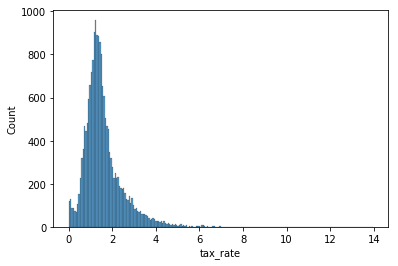

In [5]:
#### Exploring the data

# not everyone gets taxed at the same (effective?) rate; 
# majority seems to be between 1-2% but there are substantial
# counts outside that range

sns.histplot(df['tax_rate'])

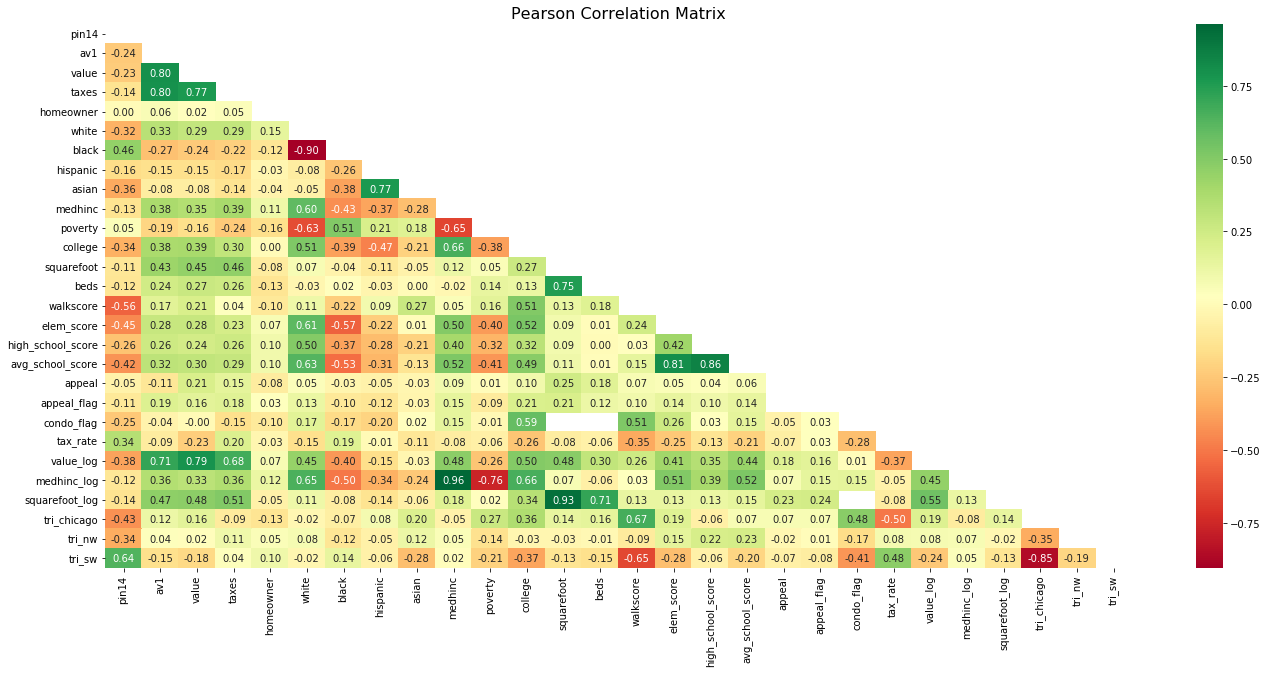

In [6]:
# Show a correlation matrix

plt.figure(figsize=(23,10))
corr = df.corr(method='pearson')

# Retrieve lower left section matrix
matrix = np.triu(corr)

ax = sns.heatmap(corr, 
                 xticklabels=corr.columns.values,
                 yticklabels=corr.columns.values,
                 annot=True, 
                 fmt='.2f',
                 cmap='RdYlGn',
                 mask=matrix)
ax.set_title('Pearson Correlation Matrix',fontsize=16)
plt.show()

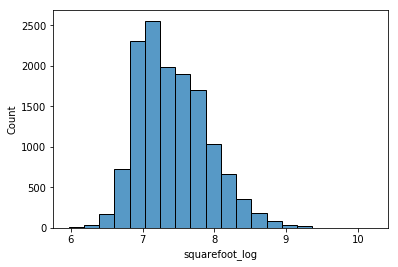

In [7]:
sns.histplot(df['squarefoot_log'], bins=20)

## Model 1: Base Model

We start by constructing a base model using as many of the variables as we can,
that make sense (this is a backward selection approach). pin14, pdir, pstreet, pcity, tcity are non-numeric attributes of properties, so we can leave them out. 

We **exclude** squarefoot_log and beds since they cause a "LinAlgError: Singular matrix" error, possibly due to perfect correlation with another field. It's not clear.

We include a calculated field "tax_rate" on the idea that the absolute dollar amount of taxes may not be a good predictor, but the (effective) rate might be.

In [8]:
x_fields = \
[
 "tri_chicago",
 "tri_nw",
 "condo_flag",
 "value_log",
 "taxes",
 "tax_rate",
 "homeowner",
 "white",
 "black",
 "hispanic",
 "asian",
 "medhinc_log",
 "poverty",
 "college",
 "walkscore",
 "elem_score",
 "high_school_score"
]

y_field = "appeal_flag"

df_subset_fields = df[x_fields + [y_field]]

# call dropna() here AFTER we've taken subset of fields, otherwise we'll lose
# meaningful rows where appeal is NA
df_subset_fields = df_subset_fields.dropna()

x = df_subset_fields[x_fields]
x = sm.add_constant(x)

y = df_subset_fields[y_field]

model = sm.Probit(y, x)
result  = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.650145
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:            appeal_flag   No. Observations:                18772
Model:                         Probit   Df Residuals:                    18754
Method:                           MLE   Df Model:                           17
Date:                Sun, 27 Feb 2022   Pseudo R-squ.:                 0.05961
Time:                        20:02:24   Log-Likelihood:                -12205.
converged:                       True   LL-Null:                       -12978.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.9676      1.216      3.263      0.001       1.584       6.351
tri_chic

/Users/surbhidhiman/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


From the above output, we can see that several fields are not statistically significant (i.e. have a P value greater than 0.05): value_log, asian, poverty, walkscore, and elem_score. So we remove these in our second model.

## Model 2: Adjusted Model

Run another model with the above statistically insignificant variables removed.


In [9]:
x_fields = \
[
 "tri_chicago",
 "tri_nw",
 "condo_flag",
 #"value_log",
 "taxes",
 "tax_rate",
 "homeowner",
 "white",
 "black",
 "hispanic",
 #"asian",
 "medhinc_log",
 #"poverty",
 "college",
 #"walkscore",
 #"elem_score",
 "high_school_score"
]

y_field = "appeal_flag"

df_subset_fields = df[x_fields + [y_field]]

# call dropna() here AFTER we've taken subset of fields, otherwise we'll lose
# meaningful rows where appeal is NA
df_subset_fields = df_subset_fields.dropna()

x = df_subset_fields[x_fields]
x = sm.add_constant(x)

y = df_subset_fields[y_field]

model = sm.Probit(y, x)
result  = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.650281
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:            appeal_flag   No. Observations:                18772
Model:                         Probit   Df Residuals:                    18759
Method:                           MLE   Df Model:                           12
Date:                Sun, 27 Feb 2022   Pseudo R-squ.:                 0.05942
Time:                        20:02:28   Log-Likelihood:                -12207.
converged:                       True   LL-Null:                       -12978.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.9580      0.430      4.554      0.000       1.115       2.801
tri_chic

As shown below, the accuracy of our model is 61.8%.

In [10]:
y_pred = result.predict(x)

def count_correct_predictions(actual, pred):
    correct_count = 0
    for pair in zip(actual, pred):
        binned = 1 if pair[1] >= 0.5 else 0
        if pair[0] == binned:
            correct_count = correct_count + 1
    return correct_count

# accuracy
print("accuracy as pct: %f" % (count_correct_predictions(y, y_pred) / len(y),))

accuracy as pct: 0.618794


We calculate the average partial effects to get a rough sense of the impacts of changes to the independent variables at their average. This is approximate since the output of Probit is non-linear. For more precise changes, we would have to calculate the differences between specific values.

In [11]:
def calculate_ape(x, result, field):
  linear_models = x.dot(result.params)
  pdfs = scipy.stats.norm.pdf(linear_models)
  partial_effects = pdfs * result.params[field]
  ape = partial_effects.mean()
  return ape

def display_ape_for_all_fields(x, result):
  """
  Display APE values for all fields, sorted from highest to lowest values
  """
  ape_results = []
  for field in result.params.keys():
    if field != 'const':
      ape_results.append([field, calculate_ape(x, result, field)])
  ape_results_sorted = sorted(ape_results, key=lambda x: x[1])
  ape_results_sorted.reverse()
  for record in ape_results_sorted:
    print(record[0], round(record[1], 4))

display_ape_for_all_fields(x, result)

tri_chicago 0.0926
tax_rate 0.0504
homeowner 0.0277
college 0.0048
high_school_score 0.0034
taxes 0.0
hispanic -0.0035
white -0.0043
black -0.0052
tri_nw -0.0363
medhinc_log -0.0588
condo_flag -0.1516


## Factors affecting whether there is an appeal

Note in particular the findings regarding race and income in bold.

_No Impact_

Variables that had almost no impact are college, high_school_score, and taxes, and the **race** variables. A change in any of these variables by a unit of 1 would result in less than 1% change in the probability of appeal.

_Positive determinants_

Being in Chicago increases the likelihood of appeal by 9.2%.

A 1% increase in the tax_rate corresponds with 5.0% increase in the likelihood of appeal.

Homeowner-occupied properties have a 2.7% higher likelihood of appeal.

_Negative determinants_

Being in the Northwest suburbs results in a 3.6% decrease in likelihood of appeal.

A $1000 change in the **median household income** in the property's census tract is associated with -5.9% change in the likelihood of appeal. (this is a Level-Log relationship)

Condominiums are 15.1% less likely to file an appeal.

# Final Project: Question 2

- Which factors affect the monetary rewards of appealing? 
- What influences how much money one might gain from a successful appeal?

Utilize multivariate OLS. Our goal is to understand whether there is bias or unfairness in the tax system.

In [12]:
df = pd.read_csv('project2data.csv')

print('Dataset Description:')
print(' Original Format: comma-separated values file')
print(' Observations: Random sample of property tax appeals within Cook County')
print(' Number of observations (rows):', df.shape[0])
print(' Number of features (columns):', df.shape[1])
print(' Feature names:  ',
      ', '.join([(element + "\n\t\t") if (index % 4 ==0) else element \
                for index, element in enumerate(sorted(df.columns), start=1)]))
print(" Dependent variable: appeal")
print("   *appeal = dollar amount deducted from assessed value after property owner appealed. If NA there was no appeal.")
print(" Source: Cook County Assessor's Office")
print(' Contact: datascience@cookcountyassessor.com')

Dataset Description:
 Original Format: comma-separated values file
 Observations: Random sample of property tax appeals within Cook County
 Number of observations (rows): 19036
 Number of features (columns): 26
 Feature names:   appeal, asian, av1, avg_school_score
		, beds, black, college, condo
		, elem_score, high_school_score, hispanic, homeowner
		, medhinc, pcity, pdir, pin14
		, poverty, pstreet, squarefoot, taxes
		, tcity, tri, value, walkfac
		, walkscore, white
 Dependent variable: appeal
   *appeal = dollar amount deducted from assessed value after property owner appealed. If NA there was no appeal.
 Source: Cook County Assessor's Office
 Contact: datascience@cookcountyassessor.com


# Data Quality - Review Preprocessing

Take a high-level review of the data and remap when necessary.

In [13]:
# Review continuous features
df.describe()

,pin14,av1,value,taxes,homeowner,white,black,hispanic,asian,medhinc,poverty,college,squarefoot,beds,walkscore,elem_score,high_school_score,avg_school_score,appeal
count,1.903600e+04,1.899100e+04,1.903600e+04,19036.000000,19036.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,13915.000000,13915.000000,19036.000000,19036.000000,19036.000000,19036.000000,9.018000e+03
mean,1.806325e+13,3.036896e+04,3.564597e+05,4972.586580,0.426087,0.625657,0.205279,0.186143,0.139870,67020.153960,0.135024,0.318044,1908.737478,3.648653,69.779838,5.453719,5.394883,5.644411,5.394141e+03
std,5.788279e+12,2.961622e+04,3.641909e+05,4233.282368,0.494520,0.274867,0.296543,0.214204,0.118632,26266.301109,0.099465,0.212173,1167.077974,1.701771,23.504392,2.406259,2.865633,2.223499,2.029286e+04
min,9.253050e+12,-1.045572e+06,5.000000e+03,0.000000,0.000000,0.001088,0.000789,0.001889,0.000000,9550.000000,0.003604,0.004178,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000e+00
25%,1.418130e+13,1.534750e+04,1.750000e+05,2479.315050,0.000000,0.499139,0.020925,0.053135,0.053844,47972.000000,0.065292,0.134969,1151.000000,3.000000,55.000000,3.000000,3.000000,4.000000,0.000000e+00
50%,1.704110e+13,2.367500e+04,2.660000e+05,3940.760000,0.000000,0.703167,0.051095,0.091340,0.099713,63529.000000,0.112022,0.265332,1567.000000,3.000000,75.000000,6.000000,5.000000,6.000000,1.177500e+03
75%,2.016100e+13,3.680350e+04,4.130000e+05,6088.760125,1.000000,0.851731,0.261715,0.217768,0.194202,84167.000000,0.170868,0.505770,2297.000000,4.000000,89.000000,7.000000,8.000000,7.000000,4.375000e+03
max,3.331210e+13,7.639090e+05,1.500000e+07,133258.690000,1.000000,0.970822,0.993390,0.979010,0.896609,192143.000000,0.776376,0.766168,27270.000000,24.000000,100.000000,10.000000,10.000000,10.000000,1.164486e+06


In [14]:
# Drop duplicate rows
print("Total df row count: ",len(df))
print("Row count after dropping duplicate rows: ", len(df.drop_duplicates()))
df = df.drop_duplicates().reset_index(drop=True) 

Total df row count:  19036
Row count after dropping duplicate rows:  18904


In [15]:
# Data Quality Review for each feature individually and remap when necessary
for feature in sorted(list(df.columns)):
    # Feature Summary section
    print(feature,':  data type:',str(df.dtypes[feature]))
    print('       unique values:',len(df[feature].unique()))
    if len(df[feature].unique()) < 20 and not isinstance(df[feature], str):
        print("    Original unique values for review:", str(df[feature].unique()))
    
    if feature == 'walkfac':
        Walkfac_dict = {'Car-Dependent': '1',
                        'Somewhat Walkable': '2',
                        'Very Walkable': '3',
                        "Walker's Paradise": '4'
                            }
        df[feature] = df[feature].map(Walkfac_dict)
        print("    New unique values for review:", str(sorted(df[feature].unique())))
    if feature == 'condo':
        Walkfac_dict = {'Non-condo': 0,
                        'Condominium': 1
                            }
        df[feature] = df[feature].map(Walkfac_dict)
        print("    New unique values for review:", str(sorted(df[feature].unique())))
    if feature == 'tri':
        # Convert data type to category
        df[feature] = df[feature].astype('category')
        print("New data type:",str(df.dtypes[feature]) )    
    if feature == 'pin14':
        # Convert data type to category
        df[feature] = df[feature].astype('str')
        print("New data type:",str(df.dtypes[feature]))

appeal :  data type: float64
       unique values: 4302
asian :  data type: float64
       unique values: 1108
av1 :  data type: float64
       unique values: 15796
avg_school_score :  data type: int64
       unique values: 10
    Original unique values for review: [ 4  9  2  6  8  3  7  5  1 10]
beds :  data type: float64
       unique values: 21
black :  data type: float64
       unique values: 1110
college :  data type: float64
       unique values: 1109
condo :  data type: object
       unique values: 2
    Original unique values for review: ['Non-condo' 'Condominium']
    New unique values for review: [0, 1]
elem_score :  data type: int64
       unique values: 10
    Original unique values for review: [ 1 10  5  8  2  7  4  9  6  3]
high_school_score :  data type: int64
       unique values: 10
    Original unique values for review: [ 6  8  2 10  1  5  4  9  7  3]
hispanic :  data type: float64
       unique values: 1110
homeowner :  data type: int64
       unique values: 2
    Or

In [16]:
# Break pin14 feature into subcomponents and drop
# Per docs:
# All PINs are 14 digits: 2 digits for area + 2 digits for sub area + 2 digits for block + 2 digits for parcel + 4 digits for the multicode
# NOTE: Docs do not account for meaning of full 14 digits (above adds up to 12; unclear of any meaning for last 2 digits)
df['area']      = df.pin14.str[0:2]
df['subarea']   = df.pin14.str[2:4]
df['block']     = df.pin14.str[4:6]
df['parcel']    = df.pin14.str[6:8]
df['multicode'] = df.pin14.str[8:12]
df = df.drop(columns='pin14')

# Review feature unique values
for feature in ['area','subarea','block','parcel','multicode']:
    # Feature Summary section
    print(feature, '  unique values:',len(df[feature].unique()))
    if len(df[feature].unique()) < 20 and not isinstance(df[feature], str):
        print("    Original unique values for review:", str(df[feature].unique()))

# Drop less useful features based on low cardinality
df = df.drop(columns='parcel')
df = df.drop(columns='multicode')

area   unique values: 26
subarea   unique values: 42
block   unique values: 41
parcel   unique values: 1
    Original unique values for review: ['00']
multicode   unique values: 1
    Original unique values for review: ['0000']


In [17]:
# Encode categorical features; Always drop one column to prevent multicollinearity issues
df = pd.get_dummies(df, columns=['walkfac'], prefix='walkfac', prefix_sep='_', drop_first=True)
df = pd.get_dummies(df, columns=['tri'], prefix='tri', prefix_sep='_', drop_first=True)

In [18]:
# create tax rate (Jeff's code)
df['tax_rate'] = df['taxes'] / df['value'] * 100
df = df.drop(columns='taxes')

## Data Quality - Missingness

Assess and handle missing data

In [19]:
# Review missingness
print("Feature_________________Missing Value Count")
print(df.isna().sum())
print("\ndf row count:",len(df))

Feature_________________Missing Value Count
pdir                                  5439
pstreet                                  1
pcity                                    1
tcity                                    0
condo                                    0
av1                                     45
value                                    0
homeowner                                0
white                                  122
black                                  122
hispanic                               122
asian                                  122
medhinc                                122
poverty                                122
college                                122
squarefoot                            5118
beds                                  5118
walkscore                                0
elem_score                               0
high_school_score                        0
avg_school_score                         0
appeal                                9982
area      

In [20]:
# We only need those who appealed for this question (>=0); drop those who did not appeal (NaN)
df = df[df.appeal.notnull()]
print("Row count after dropping null appeal observations:",len(df))

Row count after dropping null appeal observations: 8922


In [21]:
# Drop features based on missingness (>10%) (not candidate for imputation)
## squarefoot and beds are each missing 2567 observations; missingness has 1-1 correlation
df = df.drop(columns='pdir')       # Missing 2353/8922 
df = df.drop(columns='squarefoot') # Missing 2567/8922 
df = df.drop(columns='beds')       # Missing 2567/8922 

In [22]:
# Manual review finds missingness is 1-1 for white, black, hispanic, asian, medhinc, poverty, and college features.
## Missing 91/8922 observations (~1%); opted to drop these.
df = df[df.college.notnull()]

In [23]:
# Review missingness of data; final row count 8831
print("Feature_________________Missing Value Count")
print(df.isna().sum())
print("\ndf row count:",len(df))

Feature_________________Missing Value Count
pstreet                               0
pcity                                 0
tcity                                 0
condo                                 0
av1                                   0
value                                 0
homeowner                             0
white                                 0
black                                 0
hispanic                              0
asian                                 0
medhinc                               0
poverty                               0
college                               0
walkscore                             0
elem_score                            0
high_school_score                     0
avg_school_score                      0
appeal                                0
area                                  0
subarea                               0
block                                 0
walkfac_2                             0
walkfac_3                           

# Additional Preprocessing

In [24]:
# Create new feature log_appeal
# ## Exclude where appeal = 0 because these are unsuccessful appeals (no monetary reward).
df = df[(df['appeal']>0)]
df['log_appeal'] = np.log(df['appeal'])

# Create new variables for right skewed distributions on certain feature variables 
df['log_value'] = np.log(df['value'])
df['log_medhinc'] = np.log(df['medhinc'])


# Convert all continuous features to float32 (aligns w/ regression modeling package requirements in next section)
cols = ['condo', 'av1', 'log_value', 'homeowner',
       'white', 'black', 'hispanic', 'asian', 'log_medhinc', 'poverty', 'college',
       'walkscore', 'elem_score', 'high_school_score', 'avg_school_score',
       'area', 'subarea', 'block', 'walkfac_2', 'walkfac_3', 'walkfac_4',
       'tri_Northwest Suburban Cook County',
       'tri_Southwest Suburban Cook County', 'tax_rate', 'log_appeal'
       ]
for col in cols:
    df[col] = df[col].astype('float32')

# Removes spaces in col name
df.rename(columns={'tri_Southwest Suburban Cook County': 'tri_SouthwestSuburbanCookCounty', 'tri_Northwest Suburban Cook County': 'tri_NorthwestSuburbanCookCounty'}, inplace=True)


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5474 entries, 2 to 18903
Data columns (total 31 columns):
pstreet                            5474 non-null object
pcity                              5474 non-null object
tcity                              5474 non-null object
condo                              5474 non-null float32
av1                                5474 non-null float32
value                              5474 non-null int64
homeowner                          5474 non-null float32
white                              5474 non-null float32
black                              5474 non-null float32
hispanic                           5474 non-null float32
asian                              5474 non-null float32
medhinc                            5474 non-null float64
poverty                            5474 non-null float32
college                            5474 non-null float32
walkscore                          5474 non-null float32
elem_score                         5474 no

In [26]:
# Scale continuous features (normalization); Reduces model weighting on value size
# cols_to_norm = [
#   'av1', 'value', 'white', 'black', 'hispanic', 'asian',
#   'medhinc', 'poverty', 'college', 'walkscore', 'elem_score',
#   'high_school_score', 'avg_school_score', 'tax_rate'
#   ,'area', 'subarea', 'block'
#   ]
# df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# The scaling did not change the results - so this is skipped for now. 

In [27]:
# Move log_appeal to first position
first_column = df.pop('log_appeal')
df.insert(0, 'log_appeal', first_column)

# Remove unwieldy string columns
df = df.drop(columns=['pstreet', 'pcity', 'tcity']) 

# Remove columns converted to natural log 
df = df.drop(columns=['value', 'medhinc']) 

# Remove poorly defined column per Jeff's conversation w/ TA
df = df.drop(columns='av1') 

df.head()

,log_appeal,condo,homeowner,white,black,hispanic,asian,poverty,college,walkscore,...,subarea,block,walkfac_2,walkfac_3,walkfac_4,tri_NorthwestSuburbanCookCounty,tri_SouthwestSuburbanCookCounty,tax_rate,log_value,log_medhinc
2,8.342602,0.0,0.0,0.507349,0.214669,0.096806,0.244488,0.263047,0.344634,82.0,...,8.0,42.0,0.0,1.0,0.0,0.0,0.0,0.853575,14.126097,10.402140
3,10.574108,0.0,0.0,0.884098,0.015355,0.087505,0.063736,0.011499,0.517047,76.0,...,19.0,13.0,0.0,1.0,0.0,0.0,0.0,0.294599,13.903064,11.435925
7,9.189424,0.0,1.0,0.884189,0.048890,0.040915,0.048544,0.079787,0.696402,94.0,...,33.0,41.0,0.0,0.0,1.0,0.0,0.0,0.969112,13.715691,11.356599
8,10.228140,0.0,0.0,0.685848,0.083346,0.254261,0.178264,0.142172,0.462252,93.0,...,5.0,32.0,0.0,0.0,1.0,0.0,0.0,1.581288,13.394297,11.044888
9,8.032685,0.0,0.0,0.628940,0.039828,0.495415,0.264470,0.137874,0.278220,89.0,...,13.0,30.0,0.0,1.0,0.0,0.0,0.0,1.852642,12.779873,10.847258


## EDA

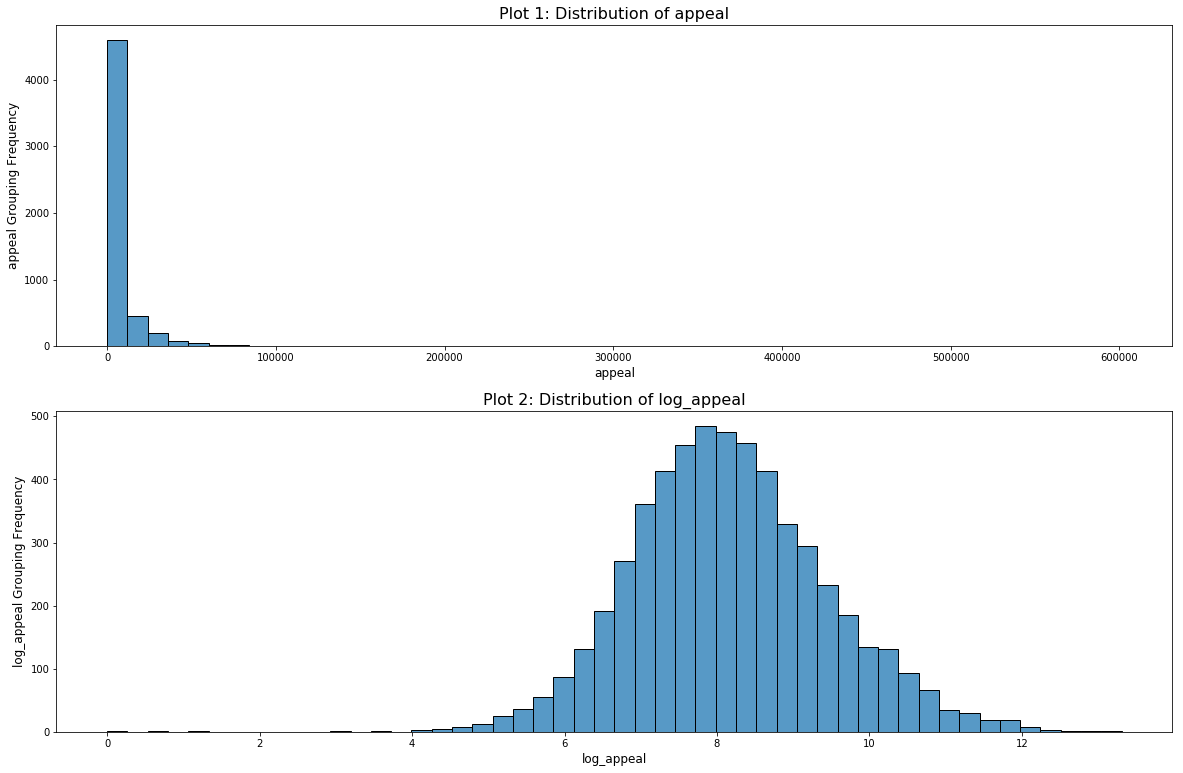

In [28]:
# Review dependent variable: appeal
plt.figure(figsize=(20,13))
plt.subplot(2, 1, 1)
ax1 = sns.histplot(df["appeal"], bins = 50, kde=False)
ax1.set_xlabel("appeal",fontsize=12)
ax1.set_ylabel("appeal Grouping Frequency",fontsize=12)
ax1.set_title('Plot 1: Distribution of appeal',fontsize=16)
plt.subplot(2, 1, 2)
ax1 = sns.histplot(df["log_appeal"], bins = 50, kde=False)
ax1.set_xlabel("log_appeal",fontsize=12)
ax1.set_ylabel("log_appeal Grouping Frequency",fontsize=12)
ax1.set_title('Plot 2: Distribution of log_appeal',fontsize=16)
plt.show()

# Drop appeal
df = df.drop(columns='appeal') 

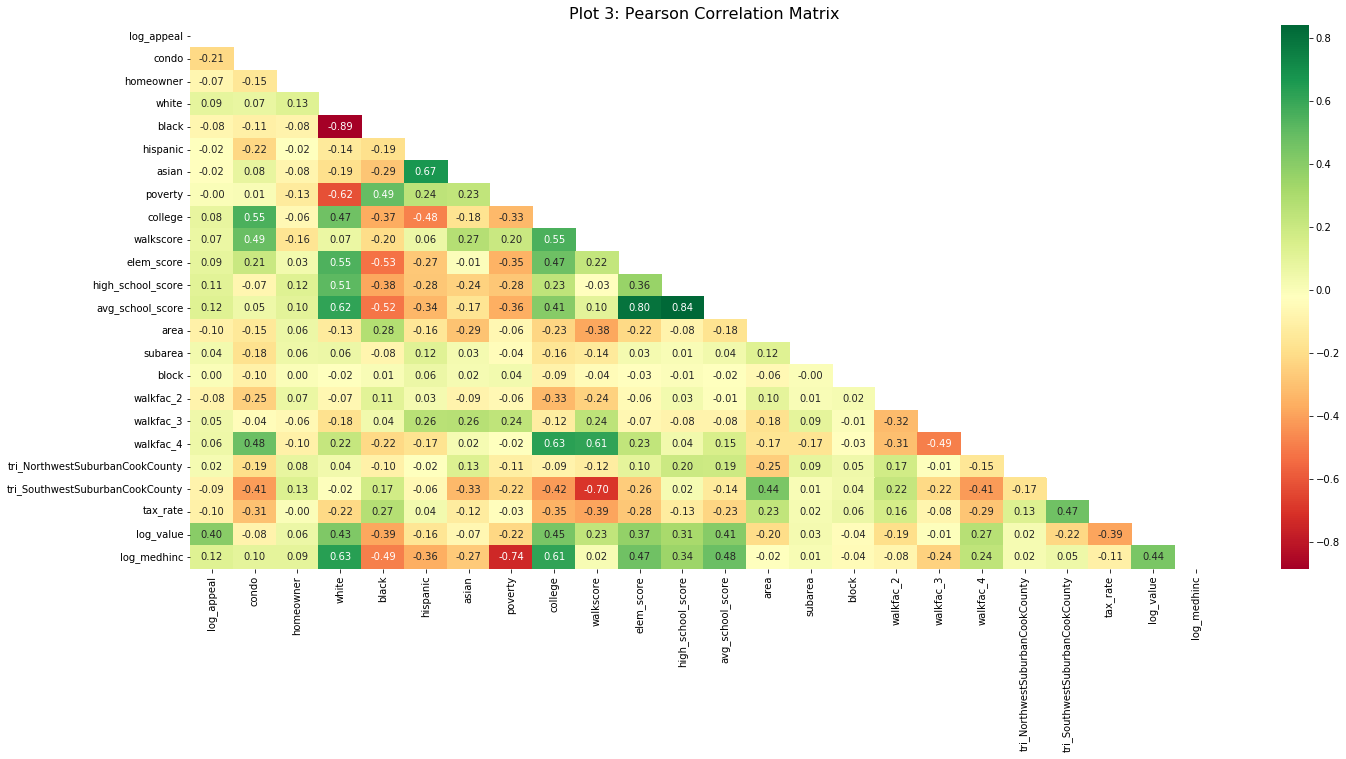

In [29]:
plt.figure(figsize=(23,10))
corr = df.corr(method='pearson')

# Retrieve lower left section matrix
matrix = np.triu(corr)

ax = sns.heatmap(corr, 
                 xticklabels=corr.columns.values,
                 yticklabels=corr.columns.values,
                 annot=True, 
                 fmt='.2f',
                 cmap='RdYlGn',
                 mask=matrix)
ax.set_title('Plot 3: Pearson Correlation Matrix',fontsize=16)
plt.show()

#### Inital Data Exploration Analysis 

In this question, we are asked to examine which features may influence how much money one might gain from a successful appeal. In an initial review of the dataset sourced from the Cook County Assessor's Office, we find that there are 19,036 samples of property tax appeals in Cook County, but after dropping duplicate columns, creating dummy variables, and cleaning out missing data, we are left with 5,474 observations to run a regression on. Additionaly, since the question asks to understand the monetary influence of a successful appeal, we only consider properties that have a value for 'appeal' - the dependent variable which describes the change in property value after appeal. As seen in the visualization above (Plot 1), the linear values in the appeal are very right skewed, and in order to correct for this, we take the natural log of 'appeal' values, and we find that these values are much more normally distributed (Plot 2) and therefore better for creating a linear model. Therefore, the dependent variable in our regression models is **log_appeal**. 

We take the following to be potential features in our OLS regression model (definitions are sourced from the data dictionary with edits according to the above data cleaning processes): 

- **condo**: Binary variable describing if property is a condo (1) or not (0). 
- **log_value**: Natural log of property sale value when it actually sold. 
- **homeowner**: Binary variable describing if homeowner occupies property (1) or  not (0). 
- **white**: Percentage of associated property census tract inhabitants identified as White on US census. 
- **black**: Percentage of associated property census tract inhabitants identified as Black on US census.
- **hispanic**: Percentage of associated property census tract inhabitants identified as Hispanic on US census.
- **asian**: Percentage of associated property census tract inhabitants identified as Asian on US census.
- **log_medhinc**: Natural log of median household income of the property. 
- **poverty**: Percentage of property’s census tract inhabitants earning below the federal poverty rate. 
- **college**: Percentage of eligible adults in the property’s census tract with a 4 year college degree. 
- **walkscore**: Walkability score on a 100 point scale, using property distance to amenities. 
- **elem_score**: Greatschools rating for closest public neighborhood elementary school. 
- **high_school_score**: Greatschools rating for closest public neighborhood high school. 
- **avg_school_score**: Average of associated elementary and high school Greatschools ratings. 
- **area**: The first two digits of 'pin14' give an area (sequential township) number. 
- **subarea**: The following two digits of 'pin14' give a subarea (section) number. 
- **block**: The following three digits of 'pin14' give a block number. 
- **walkfac_2**: Dummy Variable for 'walkfac', 1 if 'Somewhat Walkable'. 
- **walkfac_3**: Dummy Variable for 'walkfac', 1 if 'Very Walkable'. 
- **walkfac_4**: Dummy Variable for 'walkfac', 1 if 'Walker's Paradise'. 
- **tri_NorthwestSuburbanCookCounty**: Dummy Variable for 'tri', 1 if Northwest Suburban Area. 
- **tri_SouthwestSuburbanCookCounty**: Dummy Variable for 'tri', 1 if Southwest Suburban Area. 
- **tax_rate**: Rate of amount of annual taxes paid by property owner (taxes / value * 100). 



In Plot 3, we take the Pearson Correlation Matrix of these data. Some interesting notes on this plot are as follows: 

- There is a strong negative correlation between White and Black population. In the context of this problem, it would be very intersting to see how (if) race, or the general racial distribution in an area, can affect the outcome of an appeal process and if different races tend to see successful appeals at different rates and values. 
- There is also a strong positive correlation between 'elem_score' and 'avg_school_score' and between 'high_school_score' and 'avg_school_score'. Though this is expected, it might be a potential source of multicollinearity in the regression models. 




## Analysis Section

### Bivariate Linear Regression Models

In [30]:
print('Dependent Variable: log_appeal')

features = []
rsquared = []
rsquared_adj = []
pvalues = []
SER=[]
columns = list(df.columns)
columns.remove('log_appeal')
n = len(df)

for col in columns:
    formula = "log_appeal ~ " + col
    model = smf.ols(formula=formula, data=df) 
    results = model.fit()
    features.append(col)
    rsquared.append(round(results.rsquared,4))
    rsquared_adj.append(round(results.rsquared_adj,4))
    pvalues.append(round(results.pvalues[0],6))
    SSR = df.apply(lambda x: (x[col]-(results.params[0]+results.params[1]*x['log_appeal']))**2, axis=1).sum()
    SER.append((SSR/(n-2))**(1/2))


# initialize dict of lists.
data = {'features': features,
        'rsquared': rsquared,
        'rsquared_adj': rsquared_adj,
        'p_value': pvalues,
        "SER": SER}
 
# Create dataframe & display for review
linear_model_stats = pd.DataFrame(data)
linear_model_stats.sort_values(by=['rsquared_adj'], ascending=False).head(50)


Dependent Variable: log_appeal


,features,rsquared,rsquared_adj,p_value,SER
21,log_value,0.1614,0.1613,0.902772,7.452174
0,condo,0.0453,0.0451,0.000000,3.319819
11,avg_school_score,0.0150,0.0148,0.000000,3.039148
22,log_medhinc,0.0144,0.0142,0.000000,4.150073
10,high_school_score,0.0114,0.0112,0.000000,3.680016
12,area,0.0097,0.0096,0.000000,11.703930
20,tax_rate,0.0096,0.0094,0.000000,5.845366
9,elem_score,0.0081,0.0079,0.000000,3.262743
2,white,0.0076,0.0074,0.000000,10.995616
19,tri_SouthwestSuburbanCookCounty,0.0074,0.0073,0.000000,5.948324


We perform a bivariate linear regression with each feature variable on the dependent variable of log_appeal in order to have a better general understanding of how each feature may affect the appeal. As we see in the table above, the top three variables that best describe (based on adjusted R-squared value) the response are log_value, condo, and avg_school score. One interesting result of this initial analysis is that though log_value has the highest adjusted R-squared value, it also has a very high p-value, indicating that this variable is not actually statistically significant. This table gives us an indication of the types of features that we want to include in OLS model in order to best predict the appeal value. 

### Ordinary Least Squares Regression 

## Model 1: Predict log appeal

In [31]:
formula = "log_appeal ~ log_value + condo + homeowner + tri_SouthwestSuburbanCookCounty + poverty + log_medhinc + black + area + tri_NorthwestSuburbanCookCounty + walkfac_4 + walkfac_3 + walkscore + 1"
model = smf.ols(formula, df).fit()
predictions = model.predict(df)

print(formula)

print("\n Adjusted R-squared:",model.rsquared_adj)
print(model.summary())

log_appeal ~ log_value + condo + homeowner + tri_SouthwestSuburbanCookCounty + poverty + log_medhinc + black + area + tri_NorthwestSuburbanCookCounty + walkfac_4 + walkfac_3 + walkscore + 1

 Adjusted R-squared: 0.22301079609656171
                            OLS Regression Results                            
Dep. Variable:             log_appeal   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     131.9
Date:                Sun, 27 Feb 2022   Prob (F-statistic):          1.10e-290
Time:                        20:05:55   Log-Likelihood:                -8430.7
No. Observations:                5474   AIC:                         1.689e+04
Df Residuals:                    5461   BIC:                         1.697e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                    

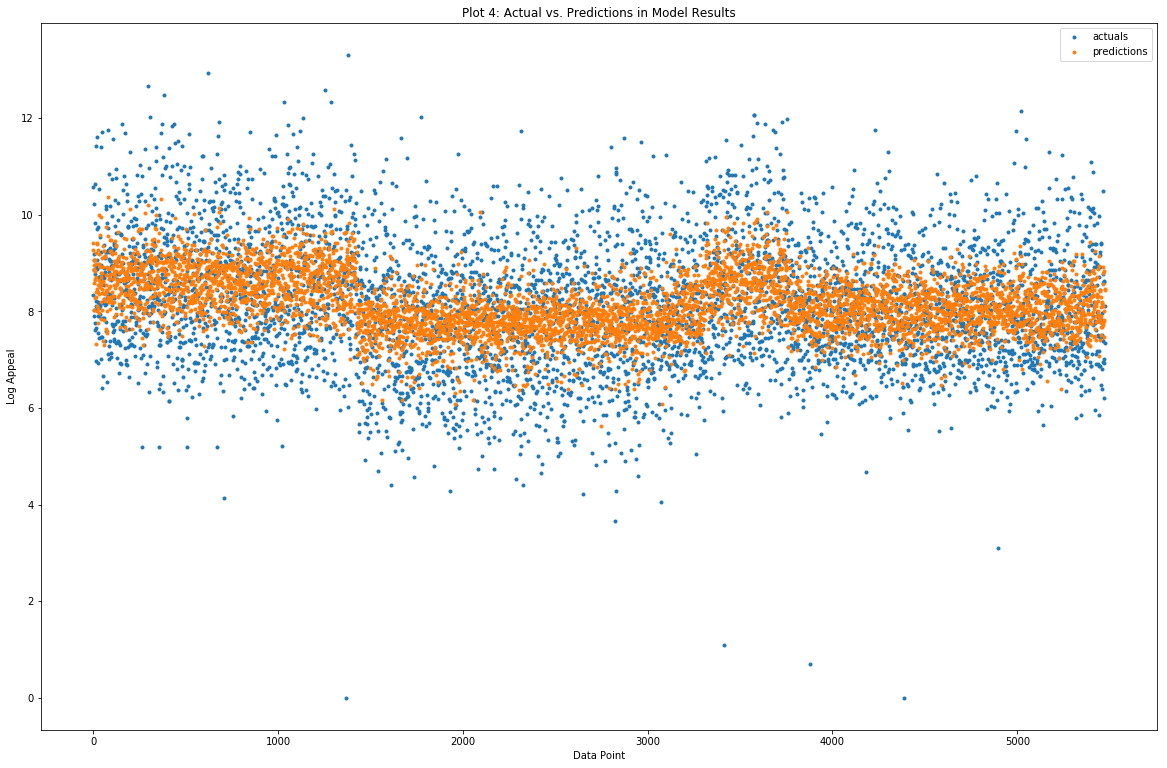

In [32]:
# Plot predictions vs. actuals 

predictions = model.predict(df)

plot_data = pd.DataFrame({
    "actuals": df['log_appeal'].to_list(), 
    "predictions": predictions.to_list()
})

plt.figure(figsize=(20,13))
plt.scatter(plot_data.index, plot_data.actuals, label='actuals', marker='.')
plt.scatter(plot_data.index, plot_data.predictions, label='predictions', marker='.')
plt.xlabel("Data Point")
plt.ylabel("Log Appeal")
plt.title("Plot 4: Actual vs. Predictions in Model Results")
plt.legend()
plt.show() 


#### Model 1: Analysis 

The reason that we chose these variables for this model is because we chose variables that we thought would be significant in from the initial review of bivariate regressions and then tested a few different combination of variables in order maximize the adjusted R-squared value and kept the variables that are statistically significant for the model. Our null hypothesis is the default null hypothesis - that each coefficient $\beta_{i} \forall i = 0$. Since we see that all our independent variables are significant, we reject the null hypothesis. 

A description of the effect that each independent variable has on outcome variable: 

- **log_value**: In the model, this variable has a p value of 0.000 and a t value of 22.242. This is an indication that this feature is very significant and precise when calculated the value of the appeal. Intuitively this makes sense, since the amount appealed is directly tied to the value of the home itself. 
- **condo**: The type of property (condo or not) also seems to have a significant effect on appeal amount with a p value of 0.000. Since the coefficient of condo is negative, it is an indication that if the property is a condo, the value of appeal may be lower then if the property were not a condo. 
- **homeowner**: This variable is also statistically significant at p = 0.000. As in the condo variable, there is a negative coefficient for homeowner, indicating that if the homeowner resides at the property, then the value of the appeal may be lower then if the homeowner doesn't reside at the property. 
- **tri_SouthwestSuburbanCookCounty**: This is also a statistically significant binary variable with a negative coefficient - similar case with homeowner and condo. 
- **poverty**: This is a statistically significant continuous variable with a high positive coefficient - indicating that the more people earning below the federal poverty rate the higher the appeal. 
- **log_medhinc**: This is also a statistically significant continuous variable with a high positive coefficient. 
- **black**: Race seems to be a  statistically significant factor in deciding appeal amount. Since the coefficient is positive for this, it may be an indication that people who identify as black may have a higher appeal. 
- **area**: This variable is also statistcally significant, but the coefficient is close to $0^-$, indicating that a big change in area may not change the appeal amount as much as other factors.  
- **tri_NorthwestSuburbanCookCounty**: This binary variable is also significant, but barely. It also has a negative coefficient, similar to tri_SouthwestSuburbanCookCounty. 
- **walkfac_4**: This binary variable is also significant. 
- **walkfac_3**: This binary variable is also significant. 
- **walkscore**: This variable is also significant. 


## Model 2: Predict the size of appeal compared to value of home

We want to estimate the response when the dependent variable is the difference between the value of the home and appeal amount. Since there is such a strong correlation between value of the home and appeal amount and the question we are being asked is what influences the monetary reduction they gain from appeal - we want to measure the reduction 
and what influences the size of that reduction. 

In [33]:
# log(a / b) = log(a) - log(b) 
df['appeal_ratio'] = df['log_appeal'] - df['log_value'] 

formula2 = "appeal_ratio ~ condo + homeowner + tri_SouthwestSuburbanCookCounty + black + log_medhinc + tax_rate + area + 1"
model2 = smf.ols(formula2, df).fit()
predictions2 = model2.predict(df)

print(formula2)

print("\n Adjusted R-squared:", model2.rsquared_adj)
print(model2.summary())

appeal_ratio ~ condo + homeowner + tri_SouthwestSuburbanCookCounty + black + log_medhinc + tax_rate + area + 1

 Adjusted R-squared: 0.08087379243347737
                            OLS Regression Results                            
Dep. Variable:           appeal_ratio   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     69.80
Date:                Sun, 27 Feb 2022   Prob (F-statistic):           5.57e-97
Time:                        20:06:06   Log-Likelihood:                -8563.1
No. Observations:                5474   AIC:                         1.714e+04
Df Residuals:                    5466   BIC:                         1.720e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err    

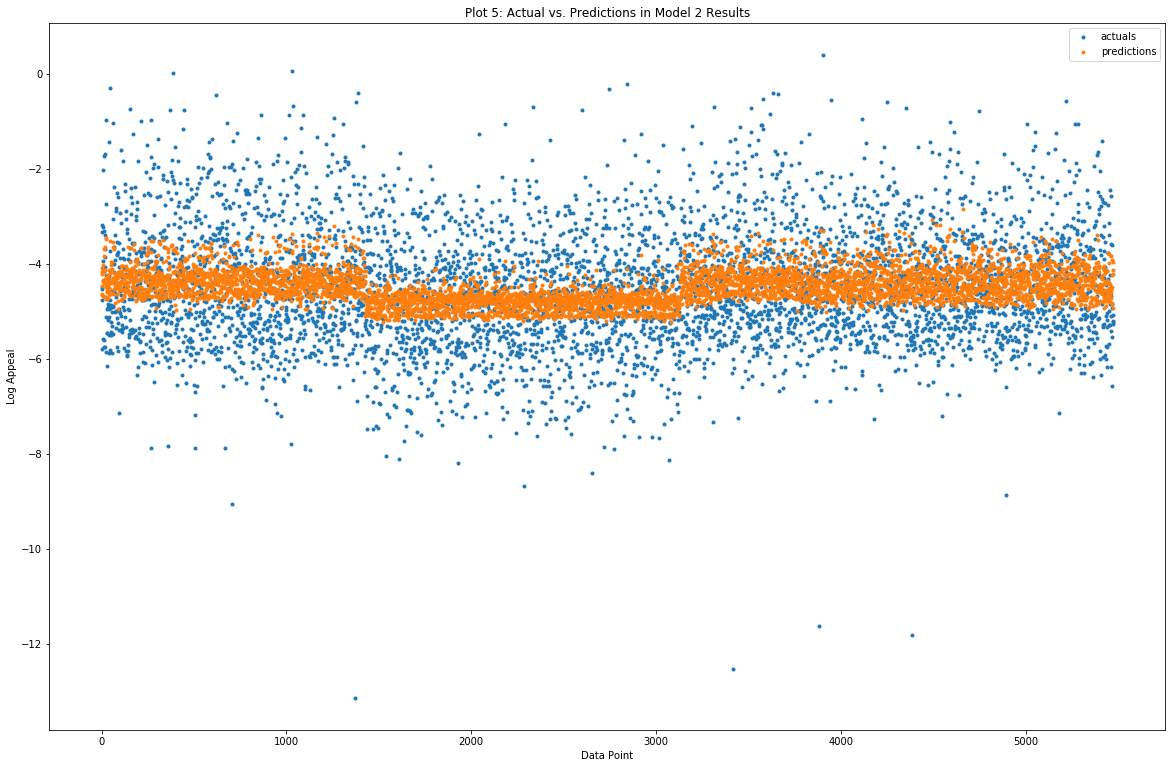

In [34]:
# Plot predictions vs. actuals 

predictions = model2.predict(df)

plot_data = pd.DataFrame({
    "actuals": (df['log_appeal'] - df['log_value']).to_list(), 
    "predictions": predictions2.to_list()
})

plt.figure(figsize=(20,13))
plt.scatter(plot_data.index, plot_data.actuals, label='actuals', marker='.')
plt.scatter(plot_data.index, plot_data.predictions, label='predictions', marker='.')
plt.xlabel("Data Point")
plt.ylabel("Log Appeal")
plt.title("Plot 5: Actual vs. Predictions in Model 2 Results")
plt.legend()
plt.show() 

#### Model 2: Analysis 

The reason that we chose these variables for this model is because we chose variables that we thought would be significant in from the initial review of bivariate regressions and then tested a few different combination of variables in order maximize the adjusted R-squared value and kept the variables that are statistically significant for the model. Our null hypothesis is the default null hypothesis - that each coefficient $\beta_{i} \forall i = 0$. Since we see that all our independent variables are significant, we reject the null hypothesis. 

All of the variables in this statistically significant - but the interesting result with this variable is that variables that were statitically insignificant in the inital experiments with the first model (and therefore removed from the model) were significant in the second model, for example 'tax_rate'. 

One main issue with this model is that although from the plot 5 above, the model seems to create predictions that are not as deviated as the actual data - this result in a very low Adjusted R-squared value of 0.081 - so this model may not be the best predictor of size of appeal adjusted by the value of the property. 



## Final Conclusions 

In conclusion, we find that the most important factors in determining if an granted is location (if property is in Chicago), tax rate, and whether a property is occupied by a homeowner or not.<br>
Important factors that may block an appeal from being granted are also location (properties in the Northwest Suburbs), if the property is a condo, and an increase of median household income corresponds with less liklihood that the appeal is granted. In order to find this, we used a binary classifier on data from the Cook County Assessor's Office - where the response variable was if an appeal was granted (1) or not (0). 
<br>
If an appeal is granted, then the important factors in considering the size of the appeal can be predicted by the value of the home, if the property is a condo or not, if a property is occupied by a homeowner or not, the location (general suburb or area of Cook County), percentage of poverty level wages, race, and walkability factor. In order to come to this conclusion, we used an Multivariate OLS model where the response variable was log of appeal amount. 
<br>
<br>
In general, there are several overlapping factors that determine if an appeal is granted and the size of the appeal. However, once an appeal has been accepted, there are additional factors to consider when looking at the size of the appeal granted. 
<br>
<br>
In order to further this study of appeals in Cook County there are other variables that were not part of this dataset that may be influential in determining the outcomes of the appeals process. Some of these variables may include outside factors such as age of the property, morgage interest rates, and the general state of the economy. Though some of these factors may be hard to quantify, they could be beneficial to include in future studies, if only to provide a control to see how the amount of appeal granted changes. 
